In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch._C import device
import torchvision
from torchvision import transforms as torchtrans  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

carrying_path = '/content/drive/My Drive/mini_project/dataset/cleaned/carrying/'
threat_path ='/content/drive/My Drive/mini_project/dataset/cleaned/threat/'
normal_path ='/content/drive/My Drive/mini_project/dataset/cleaned/normal/'


Mounted at /content/drive


In [3]:
device = torch.device("cpu")

class gun():
    def __init__(self,imgs_path):

        self.imgs_path = imgs_path
        self.img_name = [img for img in sorted(os.listdir(self.imgs_path))]

    def __getitem__(self,idx):

        image_path = os.path.join(self.imgs_path,str(self.img_name[idx]))
        img = cv2.imread(image_path)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).to(device)
        img_res = img_res.permute(2, 0, 1)
        
        return [img_res, self.img_name[idx]]

    def __len__(self):
        return len(self.img_name)

In [4]:
# Load the model
# model = TheModelClass(*args, **kwargs)

cpu_device = torch.device("cpu")

# model.load_state_dict(torch.load(LOAD_DIR+LOAD_MODEL_FILENAME))
model= torch.load('/content/drive/My Drive/mini_project/models/weapon_trained_model-1.0a.pt', map_location=torch.device('cpu'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
import matplotlib.patches as patches
def apply_nms(orig_prediction, iou_thresh=None):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    with torch.no_grad():

        fig, a = plt.subplots(1,1)
        fig.set_size_inches(5,5)
        a.imshow(img)

        min_x = torch.tensor([4000], device='cuda:0')

        min_y = torch.tensor([4000], device='cuda:0')

        max_x = torch.tensor([0], device='cuda:0')

        max_y = torch.tensor([0], device='cuda:0')
        
        for box in (target['boxes']):
            
            # box 0 1 2 3
            # min x, min y, max x, max y

            min_x = min(min_x, box[0])
            min_y = min(min_y, box[1])
            max_x = max(max_x, box[2])
            max_y = max(max_y, box[3])
            x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]


            rect = patches.Rectangle((x, y),
                                    width, height,
                                    linewidth = 2,
                                    edgecolor = 'r',
                                    facecolor = 'none')

            # Draw the bounding box on top of the image
            a.add_patch(rect)
        plt.show()
    
    return [min_x.item(), min_y.item(), max_x.item(), max_y.item()]

In [6]:
carrying_data = gun(carrying_path)

inputs = []
names = []

# do manually, 5 in a row due to GPU memory constrains 
for i in range(0, 5):
    inputs.append(carrying_data[i][0])
    names.append(carrying_data[i][1])
 

In [7]:
output = model(inputs)

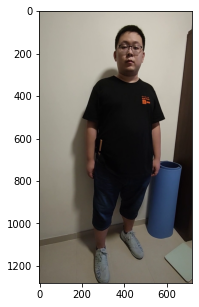

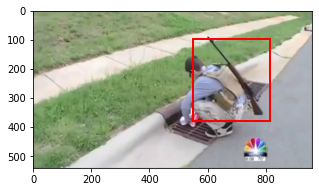

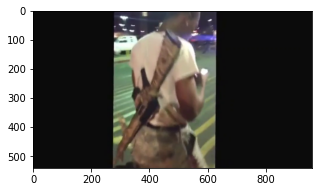

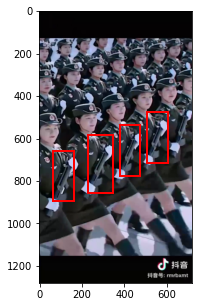

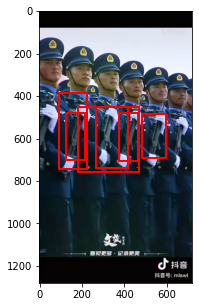

In [8]:
df = pd.DataFrame(columns=['label', 'name', 'points'])

for i in range(len(output)):
    nms_prediction = apply_nms(output[i], iou_thresh=0.7)
    min_x, min_y, max_x, max_y = plot_img_bbox(torch_to_pil(inputs[i]), nms_prediction)
    toSave = {}
    toSave['label'] = 0
    toSave['name'] = names[i]
    toSave['points'] = [min_x, min_y, max_x, max_y]

    df = df.append(toSave, ignore_index=True)


# save biggest bounding box points to csv
df.to_csv('/content/drive/My Drive/mini_project/weapon.csv', mode='a', header=False)